# The White Shark Cafe - Spectral Analysis

This notebook analyzes CROCO simulations for the manuscript (in preparation) "Annual migration of white sharks to the Eastern Subtropical Mode Water formation region" by Thomas, Wenegrat, and Block.



In [188]:
%load_ext autoreload
%autoreload 2

import time

import xarray as xr
import xgcm
import numpy as np
import xroms
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
import matplotlib.colors as colors
from glob import glob
from dask.diagnostics import ProgressBar
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

import cmocean as cm

import pyspec.spectrum as spec

import sys
sys.path.append("../src/")
import spectral_tools as st

import scipy.integrate as integrate

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [189]:
############### SAVE ? ###################
##########################################
savenc = True

In [190]:
chunks={'time':1, 's_rho':10, 's_w':10}
fileprefix = '/data/pacific/jacob/WHITESHARKCAFE/Data/MSHARK_D3/'
# Load History Files
files = sorted(glob(fileprefix+'mshark_his.*.nc'))


chunks={'time':1, 's_rho':10, 's_w':10}
#ds = xroms.open_mfnetcdf(files, chunks, xrargs={'combine':'nested'})
ds = xr.open_mfdataset(files, combine='nested', concat_dim='time', data_vars='minimal', chunks=chunks)

ds = ds.rename(time='ocean_time')
ds, grid = xroms.roms_dataset(ds, Vtransform=2)
    
ds['yearday'] = np.mod(ds.scrum_time/86400, 360)

# Load PV diagnostics
files = sorted(glob(fileprefix+'mshark_diapv*.nc'))
dspv = xr.open_mfdataset(files, combine='nested', concat_dim='time', data_vars='minimal')
dspv = dspv.rename(time='ocean_time')
dspv['yearday'] = np.mod(dspv.scrum_time/86400, 360)

# Load Momentum diagnostics
files = sorted(glob(fileprefix+'mshark_diaM*.nc'))
dsm = xr.open_mfdataset(files, combine='nested', concat_dim='time', data_vars='minimal')
dsm = dsm.rename(time='ocean_time')
dsm['yearday'] = np.mod(dsm.scrum_time/86400, 360)

# Truncate to the correct year period 
dayslice = slice(2*30, 2*30+12*30) # Sept 1 (yearday through Sept 1st
ds = ds.isel(ocean_time=dayslice)
dspv = dspv.isel(ocean_time=dayslice)
dayslice = slice(11,11+72 )
dsm = dsm.isel(ocean_time=dayslice)

ds = ds.swap_dims({'ocean_time':'yearday'})
dsm = dsm.swap_dims({'ocean_time':'yearday'})

In [191]:
# Some times and variables

a = 6371315.0 # CROCO Earth radius
m_per_deg = 2*np.pi*a/360

# Season ranges
# XXX - ARE SLICES INCLUSIVE?
SON = slice(240, 240+3*30)
DJF = list(range(330, 360)) + list(range(0,60))
DJFm = list(range(330, 360, 5)) + list(range(0,60, 5)) # hack for the 5 day mom outputs since I'm using a range here (rather than slice)
MAM = slice(60, 60 + 3*30)
JJA = slice(150, 150 + 3*30-1)
JJAm = slice(150, 235)

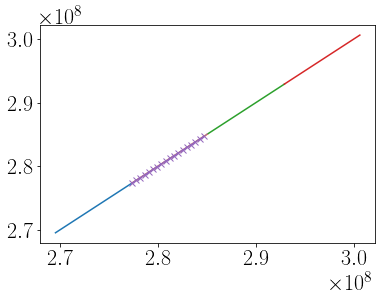

In [192]:
# Make a quick plot to verify the season decomposition from above
plt.plot(ds.ocean_time.sel(yearday=SON), ds.ocean_time.sel(yearday=SON))
plt.plot(ds.ocean_time.sel(yearday=DJF), ds.ocean_time.sel(yearday=DJF))
plt.plot(ds.ocean_time.sel(yearday=MAM), ds.ocean_time.sel(yearday=MAM))
plt.plot(ds.ocean_time.sel(yearday=JJA), ds.ocean_time.sel(yearday=JJA))

plt.plot(dsm.ocean_time.sel(yearday=DJFm), dsm.ocean_time.sel(yearday=DJFm), marker='x', )

# Interpolation

Note that before calculation variables must be interpolated to linear Cartesian grid. 

- We restrict consideration to grid cells not affected by the sponge layer (width=10 grid points).
- New grid is uniform 1.5 km (very close to original grid)

In [193]:
dx = 1.5e3
dy = dx

x = ds.dx.cumsum('xi_rho')
y = ds.dy.cumsum('eta_rho')

sponge = 10
# Calculate the length of a box fully contained in grid in lat
trimlats = ds.lat_rho[sponge:-sponge,sponge:-sponge]
bottom_lat = np.max(trimlats[0,:])
top_lat = np.min(trimlats[-1,:])
deltalat = top_lat - bottom_lat
ydistance = deltalat*m_per_deg
yi = np.arange(0, ydistance, dy)
# Calculate the length of a box fully contained in grid in lon
trimlons = ds.lon_rho[sponge:-sponge,sponge:-sponge]
deltalons = trimlons-trimlons[:,0]
distance = deltalons*m_per_deg*np.cos(trimlats*np.pi/180)
latind = np.argmin(distance[:,-1].values) # find the eta index of the least distance in domain
xi = np.arange(0, distance[latind,-1].values, dx)

nx = xi.size
ny = yi.size
lonlim = np.linspace(trimlons[0,0], trimlons[-1,0], nx)
XI, YI = np.meshgrid(yi, xi)

# Here I convert from the Cartesian grid back to the lat/lon for use with xesmf regridding
LATI = YI/m_per_deg + bottom_lat.values
#LONI = XI/(m_per_deg*np.cos(LATI*np.pi/180)) + ds.lon_rho[:,0].values[sponge:-sponge,np.newaxis]
LONI = XI/(m_per_deg*np.cos(LATI*np.pi/180)) + lonlim[:,np.newaxis]


# The below code finds the index of the depth limit for spectral calculations
zmeans = ds.z_rho0.mean(['eta_rho', 'xi_rho']).values
zind = np.argmin(np.abs(zmeans+100))

In [194]:
# Do the actual regridding
# Some editable parameters
lons = LONI
lats = LATI
which='grid'
#zind= -1 # speeds up computation for testing (should be commented out for real analysis)

# Zonal component
var = ds.u[:,zind:,:,:]
ui, _ = st.regrid(var, lons, lats, which)

# Meridional component
var = ds.v[:,zind:,:,:]
vi, _ = st.regrid(var, lons, lats, which)

/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/dask/array/core.py:380: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/dask/array/core.py:380: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be remove

## Calculate Isotropic KE Spectra by Season

In [195]:
####################################
############# SON ##################
####################################

tic = time.perf_counter()
uvar = ui.sel(yearday=SON)[:,:,1:,1:]
vvar = vi.sel(yearday=SON)[:,:,1:,1:]
specke_SON, kit = st.calculateKEspec(uvar, vvar, dx, dy)
specke_SON.name = 'SON'
print(time.perf_counter()-tic)

####################################
############# DJF ##################
####################################

tic = time.perf_counter()
uvar = ui.sel(yearday=DJF)[:,:,1:,1:]
vvar = vi.sel(yearday=DJF)[:,:,1:,1:]
specke_DJF, kit = st.calculateKEspec(uvar, vvar, dx, dy)
specke_DJF.name = 'DJF'
print(time.perf_counter()-tic)

####################################
############# MAM ##################
####################################

tic = time.perf_counter()
uvar = ui.sel(yearday=MAM)[:,:,1:,1:]
vvar = vi.sel(yearday=MAM)[:,:,1:,1:]
specke_MAM, kit = st.calculateKEspec(uvar, vvar, dx, dy)
specke_MAM.name = 'MAM'
print(time.perf_counter()-tic)

####################################
############# JJA ##################
####################################

tic = time.perf_counter()
uvar = ui.sel(yearday=JJA)[:,:,1:,1:]
vvar = vi.sel(yearday=JJA)[:,:,1:,1:]
specke_JJA, ki = st.calculateKEspec(uvar, vvar, dx, dy)
specke_JJA.name ='JJA'
print(time.perf_counter()-tic)

2790.371646665968
2845.211051810533
2946.109092656523
2992.2050626631826


## WRITE KE SPEC TO DISK

In [197]:
if savenc:
    dsspec = xr.merge([specke_SON, specke_DJF, specke_MAM, specke_JJA])
    dsspec['ki'] = ki
    dsspec['zind'] = zind
    dsspec.to_netcdf('../Data/Processed/ke_spec2.nc')

## SPECTRAL ENERGY FLUX

The spectral energy flux divergence is defined as,
$-\hat{\boldsymbol{u}}^* \cdot \widehat{\boldsymbol{u}\cdot\nabla\boldsymbol{u}}$

Thus, expanding the term gives,
$ADV  = -\hat{u}^*\widehat{uu_x} - \hat{u}^*\widehat{vu_y} -\hat{v}^*\widehat{uv_x} - \hat{v}^*\widehat{vv_y}$.

The spectral energy flux is then defined as,
$\Pi = \int_k^{k_{max}} ADV dk'$

In [198]:
# These need to be moved to src

def calculateCoSpecs(uvar, advvar, dx, dy):
    def fluxfunc(u, adv, dx,dy):
        spec2d = spec.CO_TWODimensional_spec(adv,u, dx,dy)
        return spec2d.ispec
    
    out_ef = xr.apply_ufunc(fluxfunc, 
               uvar.load(),
               advvar.load(),
               dx, 
               dy,
               input_core_dims=[['y', 'x'],['y','x'],[],[]],
               output_core_dims=[['ki']],
               #exclude_dims=set(['x'],),
               output_dtypes=[np.float64],
               vectorize=True)
    
    keflux = out_ef.mean(['yearday', 's_rho'])
    return keflux

def ProcessFluxes(YDS, ds, dsm):
    # Get the xadv yeardays (5 day output)
    yds = dsm.yearday.sel(yearday=YDS).values
    # Use them to get the corresponding velocities snapshots
    u = ds.u.sel(yearday=yds)[:,zind:,:,:]
    v = ds.v.sel(yearday=yds)[:,zind:,:,:]
    # Get the advection components
    u_xadv = dsm.u_xadv.sel(yearday=YDS)[:,zind:,:,:]
    u_yadv = dsm.u_yadv.sel(yearday=YDS)[:,zind:,:,:]
    v_xadv = dsm.v_xadv.sel(yearday=YDS)[:,zind:,:,:]
    v_yadv = dsm.v_yadv.sel(yearday=YDS)[:,zind:,:,:]

    # Everything needs to be regridded for processing
    # Do the actual regridding
    print('regridding')
    # zonal adv
    ui, regridder = st.regrid(u, lons, lats, which)
    ui = ui[:,:,1:,1:]
    u_xadvi = regridder(u_xadv)
    u_xadvi = u_xadvi[:,:,1:,1:]
    u_yadvi = regridder(u_yadv)
    u_yadvi = u_yadvi[:,:,1:,1:]

    # meridional adv
    vi, regridder = st.regrid(v, lons, lats, which)
    vi = vi[:,:,1:,1:]
    print(vi.shape)
    v_xadvi = regridder(v_xadv)
    v_xadvi = v_xadvi[:,:,1:,1:]
    v_yadvi = regridder(v_yadv)
    v_yadvi = v_yadvi[:,:,1:,1:]
    
    # Calculate cospectra
    print('calculating cospectra')
    u_x_co = calculateCoSpecs(ui, u_xadvi, dx, dy)
    u_y_co = calculateCoSpecs(ui, u_yadvi, dx, dy)
    v_x_co = calculateCoSpecs(vi, v_xadvi, dx, dy)
    v_y_co = calculateCoSpecs(vi, v_yadvi, dx, dy)
    co_specs = -u_x_co - u_y_co - v_x_co - v_y_co
    return co_specs

In [199]:
# Parameters
lons = LONI
lats = LATI
which='grid'
#zind= -2 # speeds up computation for testing (should be commented out for real analysis)

####################################
############# SON ##################
####################################
print("SON")
co_specs_SON = ProcessFluxes(SON, ds, dsm)
spec_flux_SON = integrate.cumtrapz(co_specs_SON, x=ki, initial=0)

####################################
############# DJF ##################
####################################
print("DJF")
co_specs_DJF = ProcessFluxes(DJFm, ds, dsm)
spec_flux_DJF = integrate.cumtrapz(co_specs_DJF, x=ki, initial=0)

####################################
############# MAM ##################
####################################
print("MAM")
co_specs_MAM = ProcessFluxes(MAM, ds, dsm)
spec_flux_MAM = integrate.cumtrapz(co_specs_MAM, x=ki, initial=0)

####################################
############# JJA ##################
####################################
print("JJA")
co_specs_JJA = ProcessFluxes(JJAm, ds, dsm)
spec_flux_JJA = integrate.cumtrapz(co_specs_JJA, x=ki, initial=0)

SON
regridding


/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/dask/array/core.py:380: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` paramet

(19, 16, 876, 870)


/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


calculating cospectra
DJF
regridding


/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/dask/array/core.py:380: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` paramet

(18, 16, 876, 870)


/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


calculating cospectra
MAM
regridding


/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/dask/array/core.py:380: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` paramet

(19, 16, 876, 870)


/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


calculating cospectra
JJA
regridding


/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/dask/array/core.py:380: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` paramet

(18, 16, 876, 870)


/homes/metofac/wenegrat/miniconda3/envs/WHITESHARK/lib/python3.8/site-packages/xesmf/frontend.py:438: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


calculating cospectra


## WRITE FLUX TO DISK

In [200]:
co_specs_DJF.name = 'DJF'
co_specs_MAM.name = 'MAM'
co_specs_JJA.name = 'JJA'
co_specs_SON.name = 'SON'
if savenc:
    dsflux = xr.merge([co_specs_DJF, co_specs_MAM, co_specs_JJA, co_specs_SON])
    dsflux['ki'] = ki
    dsflux['zind'] = zind
    dsflux['flux_DJF'] = (('ki'), spec_flux_DJF)
    dsflux['flux_MAM'] = (('ki'), spec_flux_MAM)
    dsflux['flux_JJA'] = (('ki'), spec_flux_JJA)
    dsflux['flux_SON'] = (('ki'), spec_flux_SON)
    dsflux.to_netcdf('../Data/Processed/ke_flux.nc')

## VERTICAL BUOYANCY PRODUCTION

Here need to make two types of plots, one is the time-depth plot of filtered w'b', the other is VBP seasonally by wavenumber.

## PLOTTING

Real plotting is done elsewhere, but these are here as a convenience.

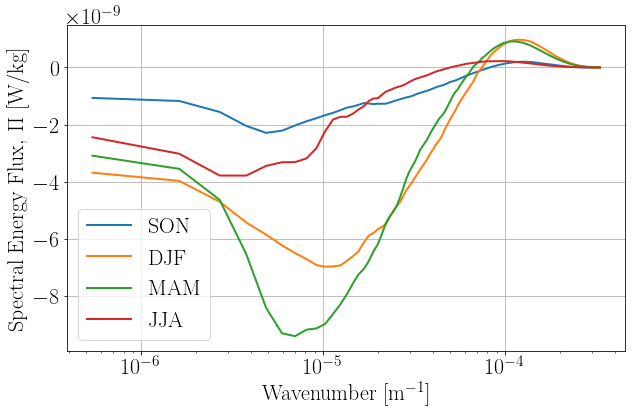

In [210]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(111)

ax.semilogx(ki, (spec_flux_SON-spec_flux_SON[-1]), label='SON', linewidth=2)
ax.semilogx(ki, (spec_flux_DJF-spec_flux_DJF[-1]), label='DJF', linewidth=2)
ax.semilogx(ki, (spec_flux_MAM-spec_flux_MAM[-1]), label='MAM', linewidth=2)
ax.semilogx(ki, (spec_flux_JJA-spec_flux_JJA[-1]), label='JJA', linewidth=2)

plt.grid()
plt.legend()
ax.set_xlabel(r"Wavenumber [m$^{-1}$]")
ax.set_ylabel(r"Spectral Energy Flux, $\Pi$ [W/kg]")
#plt.savefig('../Figures/SpecFlux.pdf')

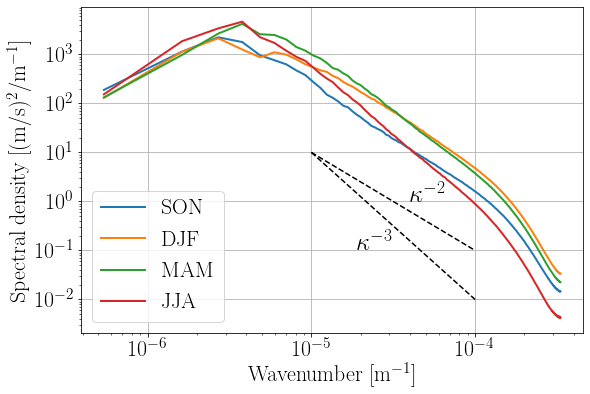

In [209]:
# Plot Spectra by Month
k3 = np.array([1e-5,1e-4])
E3 = 1/k3**3/1e14
E2 = 1/k3**2; E2 = E2/E2[0]*E3[0]


fig = plt.figure(figsize=(9,6))

ax = fig.add_subplot(111)

#plt.loglog(spec2d_u.ki,np.mean(esm[[11,0, 1],:], axis=0), label='DJF', linewidth=2) #DJF
#plt.loglog(spec2d_u.ki,np.mean(esm[[2, 3, 4],:], axis=0), label='MAM', linewidth=2) #MAM
#plt.loglog(spec2d_u.ki,np.mean(esm[[5, 6, 7],:], axis=0), label='JJA', linewidth=2) #DJF
plt.loglog(ki,specke_SON, label='SON', linewidth=2) #SON
plt.loglog(ki,specke_DJF, label='DJF', linewidth=2) #DJF
plt.loglog(ki,specke_MAM, label='MAM', linewidth=2) #MAM
plt.loglog(ki,specke_JJA, label='JJA', linewidth=2) #JJA

#plt.plot(ki,test, label='SON', linewidth=2) #DJF

plt.loglog(k3,E3,'k--')
plt.loglog(k3,E2,'k--')
plt.text(4.e-5,1e-0,r'$\kappa^{-2}$',fontsize=25)
plt.text(1.9e-5,1.05e-1,r'$\kappa^{-3}$',fontsize=25)

plt.grid()
plt.legend()
ax.set_xlabel(r"Wavenumber [m$^{-1}$]")
ax.set_ylabel(r"Spectral density [(m/s)$^2$/m$^{-1}$]")
#plt.savefig('../Figures/KESpectra.pdf', bbox_inches='tight')

In [203]:
zind

64

In [204]:
dsm

<xarray.Dataset>
Dimensions:     (auxil: 4, eta_rho: 902, eta_v: 901, s_rho: 80, s_w: 81, xi_rho: 902, xi_u: 901, yearday: 72)
Coordinates:
  * eta_rho     (eta_rho) float64 1.0 2.0 3.0 4.0 ... 899.0 900.0 901.0 902.0
  * eta_v       (eta_v) float64 1.5 2.5 3.5 4.5 5.5 ... 898.5 899.5 900.5 901.5
  * s_rho       (s_rho) float64 -0.9937 -0.9812 -0.9688 ... -0.01875 -0.00625
  * xi_rho      (xi_rho) float64 1.0 2.0 3.0 4.0 5.0 ... 899.0 900.0 901.0 902.0
  * xi_u        (xi_u) float64 1.5 2.5 3.5 4.5 5.5 ... 898.5 899.5 900.5 901.5
  * s_w         (s_w) float32 -1.0 -0.9875 -0.975 -0.9625 ... -0.025 -0.0125 0.0
    lon_rho     (eta_rho, xi_rho) float32 dask.array<chunksize=(902, 902), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float32 dask.array<chunksize=(902, 902), meta=np.ndarray>
    ocean_time  (yearday) float64 2.696e+08 2.7e+08 ... 2.998e+08 3.002e+08
  * yearday     (yearday) float64 240.0 245.0 250.0 255.0 ... 225.0 230.0 235.0
Dimensions without coordinates: auxil
Data variables:
    spherical   |S1 ...
    xl          float32 ...
    el          float32 ...
    Vtransform  float32 ...
    sc_r        (s_rho) float32 dask.array<chunksize=(80,), meta=np.ndarray>
    sc_w        (s_w) float32 dask.array<chunksize=(81,), meta=np.ndarray>
    Cs_r        (s_rho) float32 dask.array<chunksize=(80,), meta=np.ndarray>
    Cs_w        (s_w) float32 dask.array<chunksize=(81,), meta=np.ndarray>
    hc          float32 ...
    h           (eta_rho, xi_rho) float32 dask.array<chunksize=(902, 902), meta=np.ndarray>
    f           (eta_rho, xi_rho) float32 dask.array<chunksize=(902, 902), meta=np.ndarray>
    pm          (eta_rho, xi_rho) float32 dask.array<chunksize=(902, 902), meta=np.ndarray>
    pn          (eta_rho, xi_rho) float32 dask.array<chunksize=(902, 902), meta=np.ndarray>
    lon_u       (eta_rho, xi_u) float32 dask.array<chunksize=(902, 901), meta=np.ndarray>
    lat_u       (eta_rho, xi_u) float32 dask.array<chunksize=(902, 901), meta=np.ndarray>
    lon_v       (eta_v, xi_rho) float32 dask.array<chunksize=(901, 902), meta=np.ndarray>
    lat_v       (eta_v, xi_rho) float32 dask.array<chunksize=(901, 902), meta=np.ndarray>
    angle       (eta_rho, xi_rho) float32 dask.array<chunksize=(902, 902), meta=np.ndarray>
    mask_rho    (eta_rho, xi_rho) float32 dask.array<chunksize=(902, 902), meta=np.ndarray>
    time_step   (yearday, auxil) int32 dask.array<chunksize=(9, 4), meta=np.ndarray>
    scrum_time  (yearday) float32 dask.array<chunksize=(9,), meta=np.ndarray>
    u_xadv      (yearday, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(9, 80, 902, 901), meta=np.ndarray>
    u_yadv      (yearday, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(9, 80, 902, 901), meta=np.ndarray>
    u_vadv      (yearday, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(9, 80, 902, 901), meta=np.ndarray>
    u_cor       (yearday, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(9, 80, 902, 901), meta=np.ndarray>
    u_prsgrd    (yearday, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(9, 80, 902, 901), meta=np.ndarray>
    u_hmix      (yearday, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(9, 80, 902, 901), meta=np.ndarray>
    u_hdiff     (yearday, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(9, 80, 902, 901), meta=np.ndarray>
    u_vmix      (yearday, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(9, 80, 902, 901), meta=np.ndarray>
    u_nudg      (yearday, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(9, 80, 902, 901), meta=np.ndarray>
    u_rate      (yearday, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(9, 80, 902, 901), meta=np.ndarray>
    v_xadv      (yearday, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(9, 80, 901, 902), meta=np.ndarray>
    v_yadv      (yearday, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(9, 80, 901, 902), meta=np.ndarray>
    v_vadv      (yearday, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(9, 80, 901, 902), meta=np.ndarray>
    v

In [205]:
def testfunc(uv, dx,dy):
    print('howdy')
    spec2d = spec.TWODimensional_spec(uv, dx,dy)
    return spec2d.ispec

In [206]:
zlim = -1

uvar = ui[0:1,zlim:,1:,1:]#.copy(deep=True)
vvar = vi[0:10,zlim:,1:,1:]#.copy(deep=True)
#uvar = ds.u[0:1,zlim:,:,1:].copy(deep=True)
#vvar = ds.v[0:1,zlim:,1:,:].copy(deep=True)
#vvar = uvar
tic = time.perf_counter()


out_u = xr.apply_ufunc(testfunc, 
               uvar.load(),
               dx, 
               dy,
               #dask='allowed',
               input_core_dims=[['y', 'x'],[],[]],
               #input_core_dims=[['eta_rho','xi_u'],[],[]],
               #output_sizes={'ki':2,},
               output_core_dims=[['ki']],
               #exclude_dims=set(['x'],),
               output_dtypes=[np.float64],
               vectorize=True)
out_v = xr.apply_ufunc(testfunc, 
               vvar.load(),
               dx, 
               dy,
               #dask='allowed',
               input_core_dims=[['y', 'x'],[],[]],
               #input_core_dims=[['eta_v','xi_rho'],[],[]],
               output_core_dims=[['ki']],
               #exclude_dims=set(['x'],),
               output_dtypes=[np.float64],
               vectorize=True)

test = (0.5*(out_u + out_v)).mean(['yearday', 's_rho'])
print(time.perf_counter()-tic)

howdy
howdy
howdy
howdy
howdy
howdy
howdy
howdy
howdy
howdy
howdy
13.680864005349576


In [207]:
out_u

<xarray.DataArray 'u' (yearday: 1, s_rho: 1, ki: 308)>
array([[[9.85316185e+01, 2.26041696e+03, 4.99114759e+03, 2.11917849e+03,
         1.31653264e+03, 1.49825500e+03, 1.22138257e+03, 8.76634037e+02,
         5.96595590e+02, 5.06774837e+02, 2.71962735e+02, 2.48211150e+02,
         2.49174733e+02, 1.88941907e+02, 1.76259403e+02, 1.55157167e+02,
         1.28819329e+02, 1.01271651e+02, 1.02281592e+02, 6.04351056e+01,
         5.14496893e+01, 5.36709395e+01, 5.09389986e+01, 5.92759000e+01,
         3.75956553e+01, 3.12694132e+01, 2.76345465e+01, 2.79572791e+01,
         3.36867016e+01, 2.47955687e+01, 2.27112638e+01, 2.72914732e+01,
         2.97205854e+01, 3.24005026e+01, 2.59418928e+01, 2.72784208e+01,
         2.60274686e+01, 1.61673200e+01, 1.43081464e+01, 1.55400651e+01,
         1.39887279e+01, 1.21715286e+01, 1.20189583e+01, 1.37370631e+01,
         1.00588030e+01, 1.02366716e+01, 9.90827739e+00, 1.02811788e+01,
         1.01749712e+01, 8.54294228e+00, 7.74412928e+00, 8.40797081e+00,
         8.06908504e+00, 7.44304388e+00, 7.29560228e+00, 8.15911630e+00,
         7.32096533e+00, 6.76054023e+00, 4.83334904e+00, 5.32284125e+00,
         5.59392983e+00, 5.59947695e+00, 5.92174772e+00, 5.81741317e+00,
         4.83762064e+00, 4.40704518e+00, 5.03549752e+00, 3.86419566e+00,
         4.38650677e+00, 4.71471028e+00, 3.56017864e+00, 3.51404306e+00,
         3.65519241e+00, 3.55635203e+00, 3.86778975e+00, 3.38299477e+00,
         3.16964190e+00, 2.66650669e+00, 2.83540000e+00, 2.94385870e+00,
...
         4.99463495e-02, 4.49030281e-02, 4.29116080e-02, 4.12400359e-02,
         4.31296069e-02, 4.14947677e-02, 3.97749474e-02, 3.72795587e-02,
         3.98516540e-02, 3.59250418e-02, 3.55228510e-02, 3.23111940e-02,
         3.46219874e-02, 3.78017143e-02, 3.48296944e-02, 3.46154503e-02,
         3.49794931e-02, 3.39336842e-02, 3.14536478e-02, 3.17837667e-02,
         3.20507286e-02, 3.24147393e-02, 3.16012706e-02, 3.00305272e-02,
         3.01468242e-02, 3.10296647e-02, 2.89212826e-02, 3.12530089e-02,
         3.17312301e-02, 2.74032861e-02, 2.84181861e-02, 2.69611493e-02,
         2.64676391e-02, 2.69296164e-02, 2.66045750e-02, 2.71072546e-02,
         2.60738111e-02, 2.68715961e-02, 2.84860529e-02, 2.57154936e-02,
         2.69256007e-02, 2.76436070e-02, 2.70101774e-02, 2.58410419e-02,
         2.59483015e-02, 2.54151931e-02, 2.51669104e-02, 2.57786231e-02,
         2.59074870e-02, 2.42348526e-02, 2.23996674e-02, 2.42701376e-02,
         2.28283132e-02, 2.64390494e-02, 2.61680473e-02, 2.42562957e-02,
         2.39688481e-02, 2.60158717e-02, 2.63397633e-02, 2.34133671e-02,
         2.36437203e-02, 2.38040376e-02, 2.29492073e-02, 2.24878153e-02,
         2.25332942e-02, 2.21628875e-02, 2.41630437e-02, 2.44388821e-02,
         2.56124495e-02, 2.48785661e-02, 2.63083193e-02, 2.59615241e-02,
         2.54983835e-02, 2.56748706e-02, 2.50817121e-02, 2.65950543e-02,
         2.58419717e-02, 2.51188318e-02, 2.63841381e-02, 2.47394017e-02]]])
Coordinates:
  * s_rho       (s_rho) float64 -0.00625
    ocean_time  (yearday) float64 2.696e+08
  * yearday     (yearday) float64 240.0
Dimensions without coordinates: ki

In [208]:
# Calculate the isotropic spectrum
zlim = -2

uvar = ui[0:2,zlim:,1:,1:]#.copy(deep=True)
vvar = vi[0:2,zlim:,1:,1:]#.copy(deep=True)
# Note that here the duration in yearday and s_rho can be adjusted for testing purposes
#uvar = ui[0:2,zlim:,1:,1:].copy(deep=True)
#vvar = vi[0:2,zlim:,1:,1:].copy(deep=True)

#uvar = ds.u[0:1,zlim:,:,1:].copy(deep=True)
#vvar = ds.v[0:1,zlim:,1:,:].copy(deep=True)
#vvar = uvar
#uvar = ds.u[0:2,zlim:,2:,1:]
#vvar = ds.v[0:2,zlim:,1:,2:]
# This function outputs the isotropic energy spectrum (specke) and the wavenumber array (ki)
tic = time.perf_counter()
#specvec = np.vectorize(st.calculateKEspec(uvar, vvar, dy, dy))
#specke_SON, ki = st.calculateKEspec(uvar, vvar, dx, dy)

specke_SON, ki = st.calculateKEspec1(uvar.values, vvar.values, dx, dy)
test, kit = st.calculateKEspec(uvar, vvar, dx, dy)
#specke_SONv, ki = st.calculateKEspec1(vvar.values, dx, dy)
#spke = specvec(uvar, vvar, dx, dy)
#specke_SON = specke_SON+specke_SONv
print(time.perf_counter()-tic)

AttributeError: module 'spectral_tools' has no attribute 'calculateKEspec1'

In [ ]:
plt.semilogx(kit,(test-specke_SON))
#plt.plot(specke_SON)

In [ ]:
#uvar = ui[0:2,zlim:,1:,1:]
#vvar = vi[0:2,zlim:,1:,1:]

tic = time.perf_counter()

out_u = xr.apply_ufunc(testfunc, 
               uvar.load(),
               dx, 
               dy,
               #dask='parallelized',
               input_core_dims=[['eta_rho','xi_u'],[],[]],
               output_core_dims=[['x']],
               exclude_dims=set(['x'],),
               output_dtypes=[np.float64],
               vectorize=True)
out_v = xr.apply_ufunc(testfunc, 
               vvar.load(),
               dx, 
               dy,
               #dask='parallelized',
               input_core_dims=[['eta_v','xi_rho'],[],[]],
               output_core_dims=[['x']],
               exclude_dims=set(['x'],),
               output_dtypes=[np.float64],
               vectorize=True)
test = (0.5*(out_u + out_v)).mean(['yearday', 's_rho'])
print(time.perf_counter()-tic)

In [ ]:
uvar

In [ ]:
plt.scatter(LONI, LATI)
plt.plot(ds.lon_rho[:,0], ds.lat_rho[:,0], color='r')
plt.plot(ds.lon_rho[:,-1], ds.lat_rho[:,-1], color='r')
plt.plot(ds.lon_rho[0,:], ds.lat_rho[0,:], color='r')
plt.plot(ds.lon_rho[-1,:], ds.lat_rho[-1,:], color='r')

plt.plot(LONI[-1,:], LATI[-1,:], color='g')
plt.plot(LONI[0,:], LATI[0,:], color='g')
plt.plot(LONI[:,0], LATI[:,0], color='g')
plt.plot(LONI[:,-1], LATI[:,-1], color='g')


In [ ]:
x[:,0].values

In [ ]:
plt.loglog(ki, specke)

In [ ]:
print(f'Mean Dx = {ds.dx.mean().values}')
print(f'Mean Dy = {ds.dy.mean().values}')

#Interpolate to uniform 1.5 km resolution
dx = 1500 

# This should be restricted to outside the sponge region (10 points around edges)
sponge = 10
latmin = np.max(ds.lat_rho[sponge, sponge:-sponge].values)
latmax = np.min(ds.lat_rho[-sponge,sponge:-sponge].values)
lonleft = np.max(ds.lon_rho[sponge:-sponge,sponge].values)
lonrght = np.min(ds.lon_rho[sponge:-sponge,-sponge].values)

a = 6371315.0 # CROCO Earth radius
m_per_deg = 2*np.pi*a/360

lats = np.arange(latmin, latmax, step=1.5e3/m_per_deg)


In [ ]:
xi.shape

In [ ]:
plt.scatter(ds.lon_rho, ds.lat_rho)
#plt.scatter(LONI, LATI, marker='x', c='r')
plt.axhline(latmin, color='r')
plt.axhline(latmax, color='r')
plt.axvline(lonleft, color='r')
plt.axvline(lonrght, color='r')

In [ ]:
lons

In [ ]:
lontest = np.linspace(ds.lon_rho.min(), ds.lon_rho.max(), 50)
lattest = np.linspace(ds.lat_rho.min(), ds.lat_rho.max(), 20)
nx,ny = LONI.shape
tempcoarse = xroms.interpll(ds.temp.isel(ocean_time=-1, s_rho=slice(-2,-1)), LONI, LATI, which='')


In [ ]:
ui

In [ ]:
plt.pcolor(ds.lon_rho, ds.lat_rho, ds.temp.isel(ocean_time=-1, s_rho=-1), vmin=22, vmax=27)
plt.colorbar()

In [ ]:
plt.pcolor(LONI, LATI, tempi.isel(yearday=-1, s_rho=-1), vmin=22, vmax=27)
plt.colorbar()

In [ ]:
ds_out = xe.util.grid_2d(ds.lon_rho.min(), ds.lon_rho.max(),500/111e3, ds.lat_rho.min(), ds.lat_rho.max(), 500/111e3)

In [ ]:
regridder = xe.Regridder(ds, ds_out, 'bilinear')
ds_new = regridder(ds)

In [ ]:
from rasterio.warp import transform

In [ ]:
def usqrt(u):
    return np.mean(u)

def usqrtslow(uvar):
    nspec = 0
    for yd in uvar.yearday.values:
        #print(yd)
        for j in uvar.s_rho.values:
            if nspec == 0:
                spec_ke = uvar.sel(s_rho=j, yearday=yd)
            else:
                spec_ke += uvar.sel(s_rho=j, yearday=yd)
            nspec += 1 # increment counter
    #print(spec_ke.shape)
    #print(nspec)
    temp = spec_ke/nspec
    return temp

In [ ]:
#uvar = ui[0:2,zlim:,1:,1:]
#uvar = ds.u[0:2,zlim:,1:,1:]
#vvar = vi[0:2,zlim:,1:,1:]
dm = uvar.mean(['x','y','yearday', 's_rho']).values
print(f'Direct mean: {dm}')

if True:
    ufast = xr.apply_ufunc(np.mean, 
               uvar.load(), 
               input_core_dims=[['x','y']],
               #dask='parallelized',
               output_core_dims=[[]],
               #exclude_dims=set(['x', 'y'],),
               #output_dtypes=[np.float64],
               vectorize=True)
uslow = usqrtslow(uvar)
#fm = ufast.mean(['yearday','s_rho']).values
#print(f'UFUNC mean: {fm}')
sm = uslow.mean(['x','y']).values
#print(f'SLOW mean: {sm}')
dm = uvar.mean(['x','y','yearday', 's_rho']).values
print(f'Direct mean: {dm}')

In [ ]:
uvar = ui[0:2,zlim:,:,:]
dm = uvar.mean(['x','y','yearday', 's_rho']).values
print(f'Direct mean: {dm}')
uvar.load()
#uvar.compute()
#uslow = usqrtslow(uvar)

dm = uvar.mean(['x','y','yearday', 's_rho']).values
print(f'Direct mean: {dm}')



#dm = uvar.mean(['x','y','yearday', 's_rho']).values
#print(f'Direct mean: {dm}')

#dm = uvar.mean(['x','y','yearday', 's_rho']).values
#print(f'Direct mean: {dm}')


In [ ]:
uvar